In this notebook, we show how to compute kinematic controller coefficients for the model given in the paper `A Tutorial On Autonomous Vehicle Steering Controller Design, Simulation and Implementation`. 



In [23]:
from __future__ import division, print_function 
import numpy as np
import matplotlib.pyplot as plt 

# for the requirements have a look at https://python-control.readthedocs.io/en/0.8.0/intro.html


import scipy.linalg

In [24]:
# import mpld3
# mpld3.enable_notebook()

import matplotlib.style as style
 

import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter

In [25]:
pct_formatter = StrMethodFormatter('{x:.1%}')

# There are five preset seaborn themes: darkgrid, whitegrid, dark, white, and ticks
sns.set_style("darkgrid")
# sns.set() 
# blue, green, *_ = sns.color_palette()

plt.rc('figure', figsize=(12, 10))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)
plt.rc('axes', labelpad=18)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

 
**For kinematic vehicle model, vehicle velocity and the length between axles are enough**
 

In [26]:
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.

    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*X*B+R)*(B.T*X*A))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
 
    return K, X, eigVals


In [27]:
V = 10 # m/s
L = 2.9  # m - distance between the axles

In [28]:
A = np.array([[0, V], [0, 0]])          # transition matrix of the continous system
B = np.array([0, V / L]).reshape(2,1)   # control matrix of the continous system 

dt = 0.1 # discrete time step

### Discretisize the matrices Ad = I + dt*A and Bd = B*dt
x(k+1) = (I+AT)x + BTu

In [29]:
Ad = np.eye(2) + dt*A
Ad

array([[1., 1.],
       [0., 1.]])

In [30]:
Bd = B*dt
Bd

array([[0.        ],
       [0.34482759]])

## Optimization Weights

In [31]:
Q = np.eye(2) # State cost matrix 
R =5 # for the control cost 

In [32]:
dt*A

array([[0., 1.],
       [0., 0.]])

In [33]:
K, P, eigVecs = dlqr(Ad, Bd, Q, R)
K

matrix([[0.33472894, 1.61009874]])

## Create parametric vehicle model

In [34]:
def vehicle_model(V=2, dt=0.1):
    ''' V is the longitudinal speed Vx, dt is the discretization step'''
    
    # model= {'Ad':None, 'Bd':None} # model dictionary
    L = 2.9  # m - distance between the axles
    
    A = np.array([[0, V], [0, 0]])          # transition matrix of the continous system Eq.30 in the paper
    B = np.array([0, V / L]).reshape(2,1)   # control matrix of the continous system 
    
    # Discretisize the state transition and the control matrix
    Ad = np.eye(2) + dt*A
    Bd = B*dt
    
    # model['Ad'] = Ad
    # model['Bd'] = Bd
    
    return Ad, Bd
    

In [35]:
vehicle_model(V=5)

(array([[1. , 0.5],
        [0. , 1. ]]),
 array([[0.        ],
        [0.17241379]]))

## Create coefficients for a range of velocities

In [49]:
k_ey_list = [] # feedback coefficient for the lateral error e_y
k_epsi_list = [] # feedback coefficient for the yaw error e_ψ 
V_list = np.arange(1, 15, 1).tolist()
 

In [37]:
Q = np.eye(2)
Q[1, 1] = 0.1
R = 5 
Q, R

(array([[1. , 0. ],
        [0. , 0.1]]),
 5)

In [38]:
for k in range(len(V_list)):
    
    Vk = V_list[k]
    Ad, Bd = vehicle_model(Vk)
    
    K, P, eigVecs = dlqr(Ad, Bd, Q, R)
    K = K.tolist()[0]
    
    k_ey_list.append(K[0])
    k_epsi_list.append(K[1])
    
    #print(V_list[k])

Text(0, 0.5, 'Controller Gains')

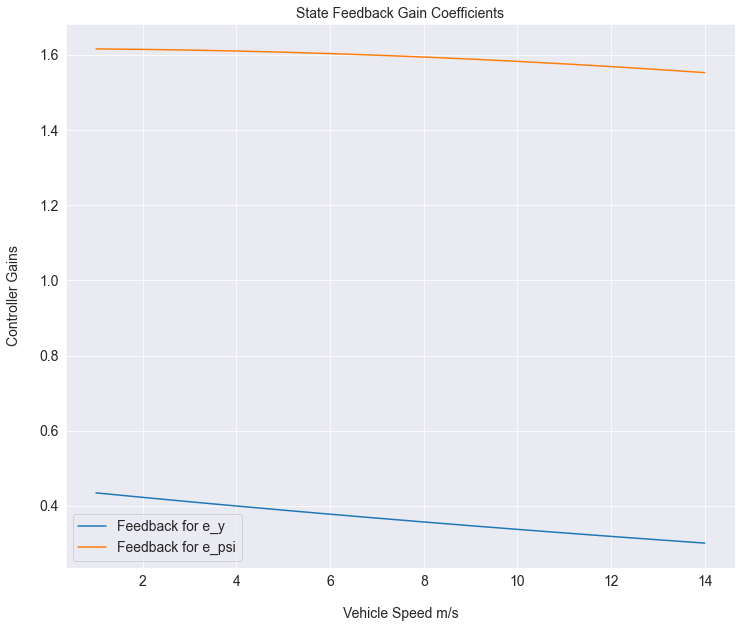

In [39]:
plt.plot(V_list, k_ey_list,label='Feedback for e_y')
plt.plot(V_list, k_epsi_list, label='Feedback for e_psi')
plt.title('State Feedback Gain Coefficients')
plt.legend()
plt.xlabel('Vehicle Speed m/s')
plt.ylabel('Controller Gains')

### Fit Linear Model to k_ey, k_epsi

In [40]:
def linear_models(V, k0, k1, vmin, vmax):
    λ_vel = (V - vmin) / (vmax-vmin)
    
    k = k0 + λ_vel * (k1-k0)
    
    return k

In [41]:
k_ey_list_lin = []
k_epsi_list_lin = []

vmin = V_list[0]
vmax = V_list[-1]



In [42]:
for k in range(len(V_list)):
    
    Vk = V_list[k]
    
    key_lin = linear_models(Vk, k_ey_list[0], k_ey_list[-1], vmin, vmax)
    kepsi_lin = linear_models(Vk, k_epsi_list[0], k_epsi_list[-1], vmin, vmax)
    
    k_ey_list_lin.append(key_lin)
    k_epsi_list_lin.append(kepsi_lin)
    # print(kepsi_lin)
    

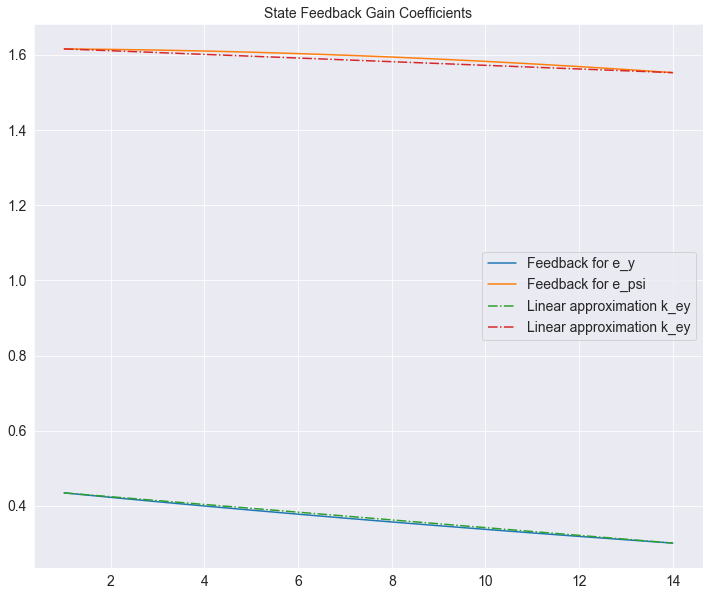

In [43]:
plt.plot(V_list, k_ey_list,label='Feedback for e_y')
plt.plot(V_list, k_epsi_list, label='Feedback for e_psi')


plt.plot(V_list, k_ey_list_lin, '-.', label='Linear approximation k_ey')
plt.plot(V_list, k_epsi_list_lin, '-.', label='Linear approximation k_ey')

plt.title('State Feedback Gain Coefficients')
plt.legend()

In [44]:
k_ey_list

[0.43491898919423294,
 0.42295790973088676,
 0.4113171013358727,
 0.3999840512836928,
 0.3889469629699572,
 0.37819472938140786,
 0.36771690704145416,
 0.3575036904743757,
 0.34754588719876767,
 0.3378348932330086,
 0.328362669069621,
 0.3191217160531123,
 0.31010505307733005,
 0.3013061935025683]

In [45]:
k_epsi_list

[1.6160854604675414,
 1.6148205601623082,
 1.6129435009194382,
 1.6104561240657582,
 1.607361021381756,
 1.6036615487753192,
 1.5993618435005015,
 1.594466844641269,
 1.5889823165042174,
 1.5829148744895065,
 1.5762720129232781,
 1.5690621342454767,
 1.561294578854867,
 1.5529796548153023]

In [46]:
aa = lambda x: (10-x)

In [47]:
aa(2)

8

In [48]:
aa = [[1, 2], [3, 4]]
np.array(aa)

array([[1, 2],
       [3, 4]])